# Classifiers

In order to run this notebook you must have installed some packages.  See [requirements](requirements.txt).  
File produced by running `conda list --export > requirements.txt`


Reference: 
* [Multi-Label Text Classification by Zuzanna Deutschman](https://towardsdatascience.com/multi-label-text-classification-5c505fdedca8).
* [Multi-label Classification Examples](https://skml.readthedocs.io/en/latest/auto_examples/index.html)

## Setting up libraries

### Importing py modules

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import re

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import BernoulliNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix


## Loading the data

In [17]:
import sys
sys.path.append(r'../src/c4v/data')

from data_loader import BratDataLoader
# from c4v.data.data_loader import BratDataLoader

file_names = [
    # 'data/processed/brat/sampled_58_30',
    '../data/processed/brat/balanced_dataset_brat',
    '../data/processed/brat/diego-sample_30-randstate_19-2020-06-15_202334',
    '../data/processed/brat/marianela-sample_50-randstate_42-2020-06-13_195818',
    '../data/processed/brat/marianela-sample_50-randstate_42-2020-06-28_093100'
]
brat_data_loader = BratDataLoader(file_names, binary=True, )
tweets = brat_data_loader.parsed_df

In [18]:
# print(tweets.columns.values)

# get the name of the columns: text and labels
TEXT_DESCRIPTION_COL = tweets.columns.values[0]
CIRCUMSTANTIAL_DESCRIPTION_COL = tweets.columns.values[1]
ELECTRICITY_DESCRIPTION_COL = tweets.columns.values[2]
GAS_DESCRIPTION_COL = tweets.columns.values[3]
GASOLINE_DESCRIPTION_COL = tweets.columns.values[4]
SOCIAL_DESCRIPTION_COL = tweets.columns.values[5]
ACCOUNT_DESCRIPTION_COL = tweets.columns.values[6]
WATER_DESCRIPTION_COL = tweets.columns.values[7]
print('Column names:')
print('\t' ,TEXT_DESCRIPTION_COL)
print('\t' ,CIRCUMSTANTIAL_DESCRIPTION_COL)
print('\t' ,ELECTRICITY_DESCRIPTION_COL)
print('\t' ,GAS_DESCRIPTION_COL)
print('\t' ,GASOLINE_DESCRIPTION_COL)
print('\t' ,SOCIAL_DESCRIPTION_COL)
print('\t' ,ACCOUNT_DESCRIPTION_COL)
print('\t' ,WATER_DESCRIPTION_COL)

Column names:
	 text
	 circumstantial-information
	 electricity
	 gas
	 gasoline
	 social-report
	 twitter-account
	 water


In [19]:

tc = tweets.copy()

# isolate the text and the labels
tc_labels = tc.drop(labels=[TEXT_DESCRIPTION_COL], axis=1)
tc_text = tc.drop(labels=[CIRCUMSTANTIAL_DESCRIPTION_COL,
                          ELECTRICITY_DESCRIPTION_COL, GAS_DESCRIPTION_COL,
                          GASOLINE_DESCRIPTION_COL, SOCIAL_DESCRIPTION_COL,
                          ACCOUNT_DESCRIPTION_COL, WATER_DESCRIPTION_COL], axis=1)

# replaces any number greater than 0 for a 1, bc we need "existance" or "not existance" of the
# label on the tweet
tc_labels = tc_labels.where(tc_labels == 0, 1)
tc_labels.head(10)

,circumstantial-information,electricity,gas,gasoline,social-report,twitter-account,water
0,1,0,0.0,1.0,1,0,0
1,1,1,0.0,0.0,0,0,0
2,1,0,0.0,1.0,1,0,0
3,1,0,0.0,1.0,0,0,0
4,1,0,0.0,1.0,1,0,0
5,1,0,0.0,1.0,1,0,0
6,1,0,0.0,1.0,1,0,0
7,1,1,0.0,0.0,0,0,0
8,0,1,0.0,0.0,1,0,0
9,1,1,0.0,0.0,0,0,0


In [20]:
binarized_tweet_labels = tc_text.merge(tc_labels, on=tc_labels.index)  # in case I need to merge them
binarized_tweet_labels = binarized_tweet_labels.drop(labels = ['key_0'], axis=1)
binarized_tweet_labels.head(10)

,text,circumstantial-information,electricity,gas,gasoline,social-report,twitter-account,water
0,#1abr en foto la fuerte cola que se re...,1,0,0.0,1.0,1,0,0
1,#22nov #guayana alta vista los olivos ...,1,1,0.0,0.0,0,0,0
2,#28dic #singasolina #ciudadguayana deberi...,1,0,0.0,1.0,1,0,0
3,#ahora estaciones esperando por la cister...,1,0,0.0,1.0,0,0,0
4,#carabobo #singasolina imposible salir en ...,1,0,0.0,1.0,1,0,0
5,#denuncia en varias parroquias del oeste ...,1,0,0.0,1.0,1,0,0
6,#singasolina@dmurolo la cola llega al km1...,1,0,0.0,1.0,1,0,0
7,#sinluz #lacabagna #laboyera #elhatillo @e...,1,1,0.0,0.0,0,0,0
8,#sinluz esta usted y su falla debe ser ...,0,1,0.0,0.0,1,0,0
9,#sinluz los caobos sabana grande la ...,1,1,0.0,0.0,0,0,0


## Vectorizing

In [21]:
# spliting the data into train and test
train, test = train_test_split(binarized_tweet_labels, random_state=42, test_size=0.30, shuffle=True)
train_text = train[TEXT_DESCRIPTION_COL].values.astype('U')
test_text = test[TEXT_DESCRIPTION_COL].values.astype('U')


# creating the vectorizer, using uni-bi-tri grams, and selecting only 10000 features.
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', 
                             ngram_range=(1,3), norm='l2', max_features = 10000)

vectorizer.fit(train_text)
vectorizer.fit(test_text)

# x_train is the vectorization of each document - sparse matrix
x_train = vectorizer.transform(train_text)

# y_train are the corresponding labels of each document - pandas.DF
y_train = train.drop(labels = [TEXT_DESCRIPTION_COL], axis=1)

# same as above, but whit will be used for testing
x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = [TEXT_DESCRIPTION_COL], axis=1)


In [22]:
x_train

<119x2331 sparse matrix of type '<class 'numpy.float64'>'
	with 1581 stored elements in Compressed Sparse Row format>

#### Explore . . .

In [23]:
# features selected by the vectorizer with uni-bi-tri grams
# x_train
features = vectorizer.get_feature_names()
features

['04142739436',
 '04142739436 corpoelecinfo',
 '04142739436 corpoelecinfo ayudaaaaaaaaa',
 '04nov',
 '04nov hora',
 '04nov hora 50pm',
 '10',
 '10 53',
 '10 53 pm',
 '10 de',
 '10 de abril',
 '100000532076',
 '100000532076 tlf',
 '100000532076 tlf 04142739436',
 '12',
 '12 dias',
 '12 dias los',
 '15pm',
 '15pm 5julio',
 '15pm 5julio rconfidencial',
 '16ene',
 '16ene impulsarlapatriaproductiva',
 '19marla',
 '19marla tarde',
 '19marla tarde de',
 '19nov',
 '19nov zonas',
 '19nov zonas de',
 '1h',
 '1h nic',
 '1h nic 100000532076',
 '1na',
 '1na gran',
 '1na gran mentira',
 '22j',
 '22j se',
 '22j se registro',
 '24jul',
 '27',
 '27 para',
 '27 para equipar',
 '28',
 '28 familias',
 '28 familias de',
 '28dic',
 '28dic singasolina',
 '28dic singasolina ciudadguayana',
 '29nov',
 '29nov alertan',
 '29nov alertan sobre',
 '30',
 '30 ya',
 '30 ya hay',
 '300',
 '300 carros',
 '300 carros sigu',
 '30pm',
 '30pm porq',
 '30pm porq no',
 '31jul',
 '31jul crisis',
 '31jul crisis electrica',
 '3

## Build a model, train and predict

Helper methods to evaluate the model

In [24]:
def report_measures(y_test, y_pred) -> None:

    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Hamming loss: ", hamming_loss(y_test, y_pred))
    
    print("F1 score:")
    print("\tmicro: ", f1_score(y_test, y_pred, average='micro'))
    print("\tmacro: ", f1_score(y_test, y_pred, average='macro'))

    print("Precision:")
    print("\tmicro: ", precision_score(y_test, y_pred, average='micro'))
    print("\tmacro: ", precision_score(y_test, y_pred, average='macro'))

    print("Recall:")
    print("\tmicro: ", recall_score(y_test, y_pred, average='micro'))
    print("\tmacro: ", recall_score(y_test, y_pred, average='macro'))

### Binary Relevance
1. with GaussianNB

In [25]:
#Binary Relevance: Naive Bayes with Bernoulli Distribution
br_classifier = BinaryRelevance(BernoulliNB())
br_classifier.fit(x_train, y_train)
br_predictions = br_classifier.predict(x_test)

report_measures(y_test, br_predictions)

Accuracy:  0.0784313725490196
Hamming loss:  0.41456582633053224
F1 score:
	micro:  0.5345911949685536
	macro:  0.4580532646657505
Precision:
	micro:  0.5089820359281437
	macro:  0.44734964292230306
Recall:
	micro:  0.5629139072847682
	macro:  0.5162284109652531


2. with LogisticRegression

In [26]:
# Binary Relevance: Logistic Regression
br_classifier1 = BinaryRelevance(LogisticRegression())
br_classifier1.fit(x_train, y_train)
br_predictions1 = br_classifier1.predict(x_test)

report_measures(y_test, br_predictions1)

# br_predictions.toarray()
# y_test

Accuracy:  0.17647058823529413
Hamming loss:  0.22408963585434175
F1 score:
	micro:  0.7241379310344827
	macro:  0.35699976767762104
Precision:
	micro:  0.7553956834532374
	macro:  0.3184949655537891
Recall:
	micro:  0.695364238410596
	macro:  0.40740740740740744


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Label Powerset


In [27]:
#Label Powerset
lp_classifier = LabelPowerset(LogisticRegression())
lp_classifier.fit(x_train, y_train)
lp_predictions = lp_classifier.predict(x_test)

report_measures(y_test, lp_predictions)

Accuracy:  0.17647058823529413
Hamming loss:  0.24929971988795518
F1 score:
	micro:  0.6509803921568628
	macro:  0.33516416165936747
Precision:
	micro:  0.7980769230769231
	macro:  0.408304244774833
Recall:
	micro:  0.5496688741721855
	macro:  0.3197438039543303


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### MLkNN

In [28]:
ml_classifier = MLkNN(k=4)
# to prevent errors when handling sparse matrices.
x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(x_test).toarray()

ml_classifier.fit(x_train, y_train)
ml_predictions = ml_classifier.predict(x_test)

report_measures(y_test, ml_predictions)

Accuracy:  0.09803921568627451
Hamming loss:  0.3025210084033613
F1 score:
	micro:  0.635135135135135
	macro:  0.46627383182908294
Precision:
	micro:  0.6482758620689655
	macro:  0.4987707504780675
Recall:
	micro:  0.6225165562913907
	macro:  0.46051180788022894


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_neighbors=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### Classifier Chain Model

In [29]:
# for the next classifier we need to remove from y-train, y-test categories which
# equal 0 for all train samples
# y_train = train.drop(labels = [TEXT_DESCRIPTION_COL], axis=1)
# y_test = test.drop(labels = [TEXT_DESCRIPTION_COL], axis=1)
# selected_labels = y_train.columns[y_train.sum(axis = 0, skipna = True) > 0].tolist()

# y_train = y_train.filter(selected_labels, axis=1)
# y_test = y_test.filter(selected_labels, axis=1)
# x_train = vectorizer.transform(train_text)
# x_test = vectorizer.transform(test_text)

cc_classifier = ClassifierChain(LogisticRegression())
cc_classifier.fit(x_train, y_train)
# print(cc_classifier.predict(x_test))
cc_predictions_proba = cc_classifier.predict_proba(x_test)

report_measures(y_test, cc_classifier.predict(x_test))

Accuracy:  0.17647058823529413
Hamming loss:  0.24929971988795518
F1 score:
	micro:  0.6509803921568628
	macro:  0.26452527788170266
Precision:
	micro:  0.7980769230769231
	macro:  0.37254901960784315
Recall:
	micro:  0.5496688741721855
	macro:  0.29100529100529104


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


t = 0.05 	 Accuracy =  0.0 	 F1 =  0.6138211382113821 	 Hamming loss =  0.5322128851540616
t = 0.06 	 Accuracy =  0.0196078431372549 	 F1 =  0.648068669527897 	 Hamming loss =  0.45938375350140054
t = 0.07 	 Accuracy =  0.0196078431372549 	 F1 =  0.644880174291939 	 Hamming loss =  0.4565826330532213
t = 0.08 	 Accuracy =  0.0196078431372549 	 F1 =  0.6433260393873086 	 Hamming loss =  0.4565826330532213
t = 0.09 	 Accuracy =  0.0196078431372549 	 F1 =  0.644736842105263 	 Hamming loss =  0.453781512605042
t = 0.1 	 Accuracy =  0.0196078431372549 	 F1 =  0.6475770925110133 	 Hamming loss =  0.4481792717086835
t = 0.11 	 Accuracy =  0.0 	 F1 =  0.642369020501139 	 Hamming loss =  0.43977591036414565
t = 0.12 	 Accuracy =  0.0 	 F1 =  0.6618705035971223 	 Hamming loss =  0.3949579831932773
t = 0.13 	 Accuracy =  0.0 	 F1 =  0.6650366748166259 	 Hamming loss =  0.38375350140056025
t = 0.14 	 Accuracy =  0.0 	 F1 =  0.6633906633906634 	 Hamming loss =  0.38375350140056025
t = 0.15 	 Accura

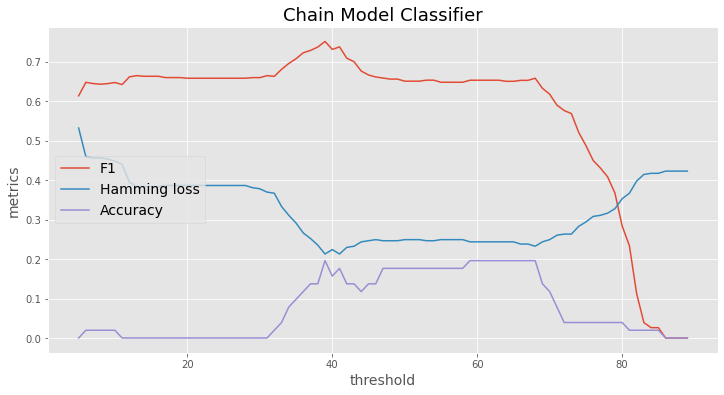

In [30]:
#for plotting metrics as a function of threashold
def plotting_metrics_function_of_threshold(model_name, cc_predictions_proba, y_test):
    th = []
    f = []
    ham = []
    ac = []

    for t in range (5,90): # threshold value
        y_pred_new = (cc_predictions_proba >= t/100).astype(int)
        print("t =" ,t/100, '\t', "Accuracy = ",accuracy_score(y_test,y_pred_new),
             '\t', "F1 = ",f1_score(y_test,y_pred_new, average="micro"), '\t',
              "Hamming loss = ",hamming_loss(y_test,y_pred_new))
        th.append(t)
        ac.append(accuracy_score(y_test,y_pred_new))
        f.append(f1_score(y_test,y_pred_new, average="micro"))
        ham.append(hamming_loss(y_test,y_pred_new))
    plt.rcParams["figure.figsize"] = (12,6)
    with plt.style.context('ggplot'):
        plt.plot(th, f)
        plt.plot(th, ham)
        plt.plot(th, ac)
        plt.legend(['F1', 'Hamming loss', 'Accuracy'], loc='center left', fontsize = 14)
        plt.ylabel("metrics", fontsize = 14)
        plt.xlabel("threshold", fontsize = 14)
        plt.title(model_name, fontsize = 18)
    plt.show()
    
plotting_metrics_function_of_threshold('Chain Model Classifier', cc_predictions_proba, y_test)

### multi label Classifier using Neural Networks

Two ways to do this:
* using TF-IDF Vectorizer
* using Word Embeddings

In [31]:
import tensorflow as tf
from tensorflow import keras

/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/

#### using TF-IDF vectorizer
For this model we will use TF-IDF vectorizer generated on [Section 1.3](#Vectorizing) to convert the sentences into vectors, then this will be passed
into the neural network.

In [32]:
# print(x_train.shape[1])
# x_train
# y_train
# x_test
# y_test

# work to be done. . .

model = keras.Sequential()
model.add(keras.layers.Dense(16, input_dim=x_train.shape[1], activation="relu"))
# model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(tweets.columns.values.shape[0] -1, activation="sigmoid"))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                37312     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 119       
Total params: 37,431
Trainable params: 37,431
Non-trainable params: 0
_________________________________________________________________


In [33]:


model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

batch_size = 20
epochs = 10

history = model.fit(x_train, y_train, batch_size, epochs, validation_data=(x_test, y_test))

results = model.evaluate(x_test, y_test, batch_size)

nn_predictions = model.predict(x_test)

Train on 119 samples, validate on 51 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
119/119 [==============================] - 0s 2ms/sample - loss: 0.6900 - acc: 0.5678 - val_loss: 0.6889 - val_acc: 0.6218
Epoch 2/10
119/119 [==============================] - 0s 90us/sample - loss: 0.6839 - acc: 0.6867 - val_loss: 0.6850 - val_acc: 0.6807
Epoch 3/10
119/119 [==============================] - 0s 89us/sample - loss: 0.6781 - acc: 0.7311 - val_loss: 0.6809 - val_acc: 0.7339
Epoch 4/10
119/119 [==============================] - 0s 92us/sample - loss: 0.6721 - acc: 0.7455 - val_loss: 0.6766 - val_acc: 0.7507
Epoch 5/10
119/119 [==============================] - 0s 101us/sample - loss: 0.6658 - acc: 0.7527 - val_loss: 0.6722 - val_acc: 0.7591
Epoch 6/10
119/119 [==============================] - 0s 105us/sample - loss: 0.6594 - acc: 0.7623 - val_loss: 0.6673 - val_acc: 0.7591
Epoch 7/10
119/119 [==============================] - 0s 108us/sample - loss: 0.6524 - acc: 0.75

In [34]:
# print(history)
print(results)
# nn_predictions
# plotting_metrics_function_of_threshold('ANN Classifier', nn_predictions, y_test)


[0.6459544172473982, 0.75630254]


In [35]:
pd_pred_prob = pd.DataFrame(nn_predictions, columns = tweets.columns.values[1:])
pd_pred = (pd_pred_prob.copy() >= 0.5)
pd_pred = pd_pred.where(pd_pred == True, 0)
pd_pred = pd_pred.where(pd_pred == False, 1)

report_measures(y_test, pd_pred.to_numpy(dtype=np.int))

Accuracy:  0.11764705882352941
Hamming loss:  0.24369747899159663
F1 score:
	micro:  0.7109634551495018
	macro:  0.35084629277414614
Precision:
	micro:  0.7133333333333334
	macro:  0.30567971869598903
Recall:
	micro:  0.7086092715231788
	macro:  0.417989417989418


/Users/marianela/opt/anaconda3/envs/ml_learning/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# pd_pred.insert(0, 'tweet', test_text)
# pd_pred

In [37]:
tw_doc = 'La cosa esta dificil con lo de la luz y todo lo demas'
tw_doc_vector = vectorizer.transform([tw_doc])

tw_pred = model.predict([tw_doc_vector])
print('Prediction: \n', tw_doc)
pd.DataFrame(tw_pred, columns = tweets.columns.values[1:])

Prediction: 
 La cosa esta dificil con lo de la luz y todo lo demas


,circumstantial-information,electricity,gas,gasoline,social-report,twitter-account,water
0,0.574558,0.546373,0.46038,0.430151,0.523295,0.444129,0.41071


#### using Word Embeddings

TBD

In [ ]:
# binarized_tweet_labels

#  these are all the labels, for now I will select only one of them
#  and we will test the classification on a single label.

# print( TEXT_DESCRIPTION_COL )
# print( CIRCUMSTANTIAL_DESCRIPTION_COL )
# print( ELECTRICITY_DESCRIPTION_COL )
# print( GAS_DESCRIPTION_COL )
# print( GASOLINE_DESCRIPTION_COL )
# print( SOCIAL_DESCRIPTION_COL )
# print( ACCOUNT_DESCRIPTION_COL )
# print( WATER_DESCRIPTION_COL )

